<a href="https://colab.research.google.com/github/mizabelsantos/demo/blob/master/TensorFlow_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensorflow with GPU

This notebook provides an introduction to computing on a [GPU](https://cloud.google.com/gpu) in Colab. In this notebook you will connect to a GPU, and then run some basic TensorFlow operations on both the CPU and a GPU, observing the speedup provided by using the GPU.


## Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Observe TensorFlow speedup on GPU relative to CPU

This example constructs a typical convolutional neural network layer over a
random image and manually places the resulting ops on either the CPU or the GPU
to compare execution speed.

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.822226408000006
GPU (s):
0.1838248100000328
GPU speedup over CPU: 20x


# # 2_TP_Cats_and_Dogs


In [3]:
import tensorflow as tf

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt

In [5]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

68608000/68606236 [==============================] - 1s 0us/step


**Création des chemins pour les ensembles de validation et de training**


In [6]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [7]:
train_cats_dir = os.path.join(train_dir, 'cats')  
train_dogs_dir = os.path.join(train_dir, 'dogs')  
validation_cats_dir = os.path.join(validation_dir, 'cats')  
validation_dogs_dir = os.path.join(validation_dir, 'dogs') 

In [18]:
!pwd

/content


**Compréhension des données**

In [8]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [9]:
print("Nombre total d'images de chats dans le training set:", num_cats_tr)
print("Nombre total d'images de chiens dans le training set:", num_dogs_tr)

print('Nombre total d\'images de chats dans le validation set:', num_cats_val)
print('Nombre total d\'images de chiens dans le validation set:', num_dogs_val)
print("--")
print("Nombre total d'images de training:", total_train)
print("Nombre total d'images de validation:", total_val)

Nombre total d'images de chats dans le training set: 1000
Nombre total d'images de chiens dans le training set: 1000
Nombre total d'images de chats dans le validation set: 500
Nombre total d'images de chiens dans le validation set: 500
--
Nombre total d'images de training: 2000
Nombre total d'images de validation: 1000


**Définition des paramètres du modèle**

In [20]:
BATCH_SIZE = 100
IMG_SHAPE  = 150 # Dans le training set on a des images de 150 x 150 pixels

**Data Augumentation**

In [21]:
 # représenter les images sous la forme d'une grille de 1 ligne et 5 colonnes où les images sont placées dans chaque colonne
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show() 

**Retourner l'image horizontalement**

In [22]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE,IMG_SHAPE))

Found 2000 images belonging to 2 classes.


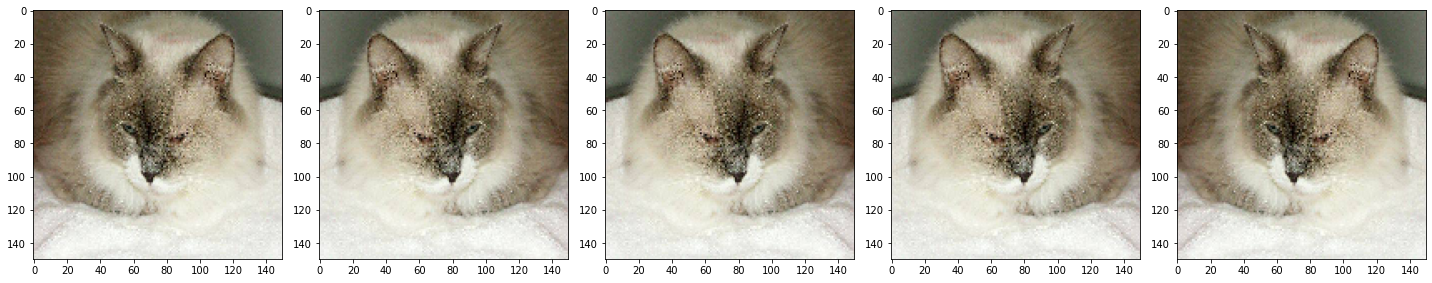

In [23]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

**Rotation de l'image**

In [25]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

Found 2000 images belonging to 2 classes.


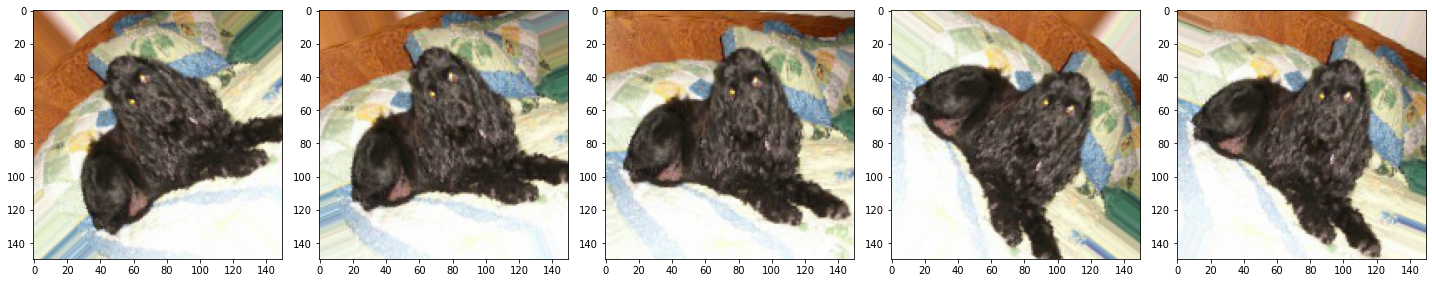

In [26]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

**Zoomer les images**

In [27]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

Found 2000 images belonging to 2 classes.


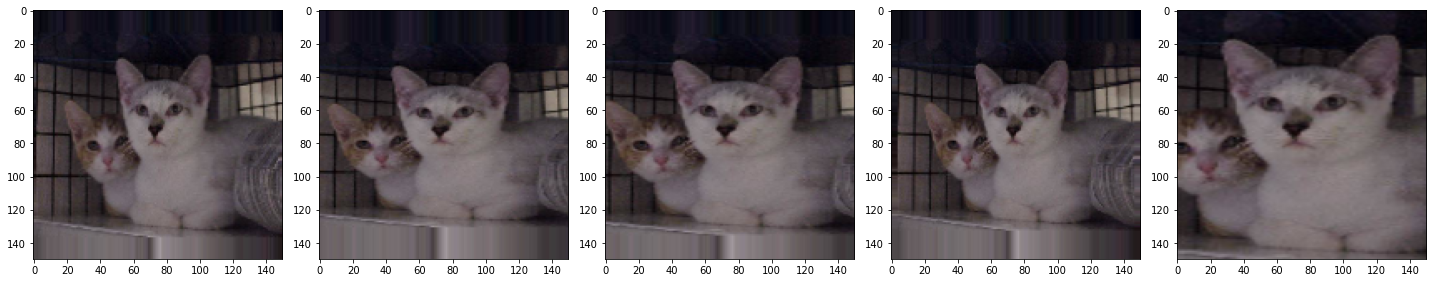

In [28]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

**Mettre le tout ensemble sur les données de training**

In [29]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


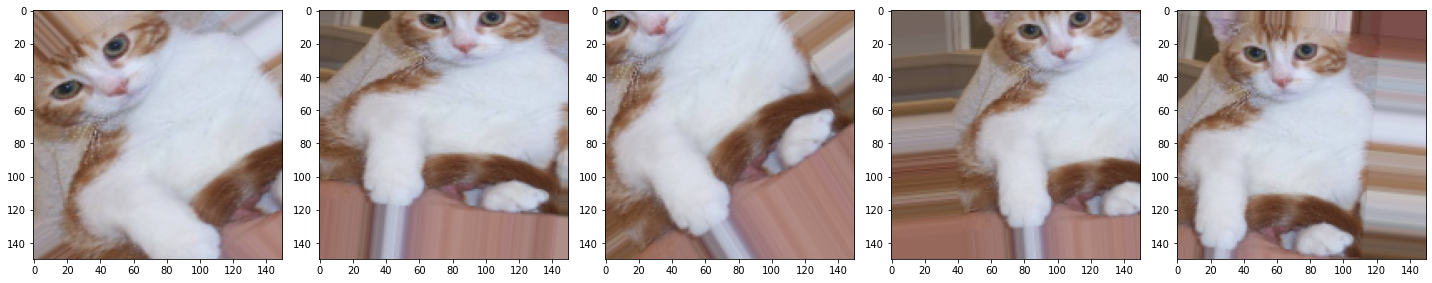

In [30]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

**Un petit rescaling du validation set**

In [31]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=validation_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


## **Création du modèle**


**Définition du modèle:**


Le modèle se compose de quatre blocs de convolution avec une couche de max-pool dans chacun d'eux. Avant les dernières couches denses, on applique un dropout à 50% On a ensuite une couche dense de 512 neurones, avec une fonction d'activation ReLu. En sortie on aura des probabilités d'appartenance à deux classes (chiens et chats), on utilisera softmax

In [49]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

**Compilation du modèle**

In [50]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

**Résumé du modèle**

In [51]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 15, 15, 128)      

**Training du modèle**

In [52]:
# du moment où nos batchs proviennent de datagenerator on utilisera fit_generator au lieu de fit
epochs=98
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Epoch 1/98
20/20 [==============================] - 20s 986ms/step - loss: 0.6970 - accuracy: 0.5095 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 2/98
20/20 [==============================] - 20s 987ms/step - loss: 0.6885 - accuracy: 0.5350 - val_loss: 0.6733 - val_accuracy: 0.5310
Epoch 3/98
20/20 [==============================] - 19s 971ms/step - loss: 0.6710 - accuracy: 0.5790 - val_loss: 0.6484 - val_accuracy: 0.6170
Epoch 4/98
20/20 [==============================] - 19s 967ms/step - loss: 0.6726 - accuracy: 0.5640 - val_loss: 0.6324 - val_accuracy: 0.6370
Epoch 5/98
20/20 [==============================] - 19s 962ms/step - loss: 0.6518 - accuracy: 0.6140 - val_loss: 0.6326 - val_accuracy: 0.6430
Epoch 6/98
20/20 [==============================] - 19s 964ms/step - loss: 0.6384 - accuracy: 0.6195 - val_loss: 0.6336 - val_accuracy: 0.6360
Epoch 7/98
20/20 [==============================] - 19s 964ms/step - loss: 0.6139 - accuracy: 0.6715 - val_loss: 0.7818 - val_accuracy: 0.5410

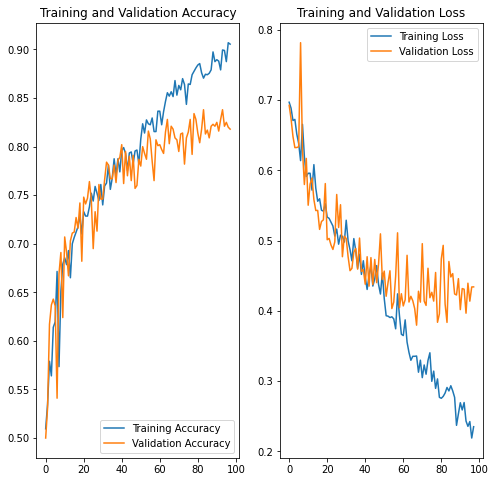

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [54]:
test_loss, test_acc = model.evaluate(val_data_gen, verbose=2)

10/10 - 3s - loss: 0.4342 - accuracy: 0.8180


In [55]:
print(test_acc)

0.8180000185966492


# # 3_TP_CIFAR_deep_learning_Convolutional_Layers
